In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import matplotlib.pyplot as plt
import math
import time
import copy
import numpy as np
from PIL import Image
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# Import Pytorch modules
import torch
from torch import optim, nn
import torch.nn.functional as F
from torchvision import transforms, models

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

### Loading the data

In [5]:
image_root = "drive/MyDrive/ControlExpert/Date_synth/images/"
all_img_files = os.listdir(image_root)
dates_data = pd.read_csv( "drive/MyDrive/ControlExpert/Date_synth/imagename_date.txt",header = None,dtype = "str")
dates_data.columns =["img_name", "date"]

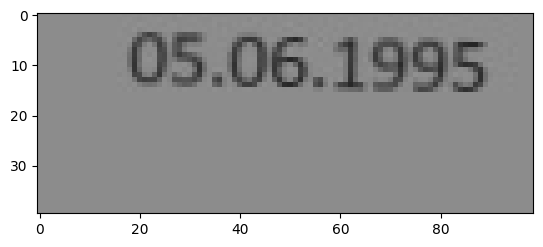

In [6]:
im = Image.open(image_root + all_img_files[2])
plt.imshow(im)

In [7]:
dates_data["dd"] = dates_data["date"].str[:2].astype(int)
dates_data["mm"] = dates_data["date"].str[2:4].astype(int)
dates_data["yy"] = dates_data["date"].str[4:].astype(int)

### Distribution of the label "Year"

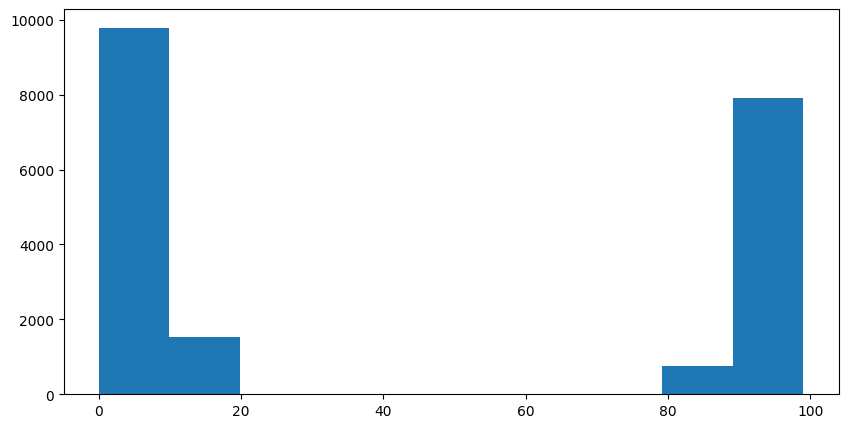

In [31]:
fig,ax = plt.subplots(figsize = (10,5))
ax.hist(dates_data["yy"], label = "years")
plt.show()

### Creating classification task, creation of labels.

In [9]:
dates_data["yyyy"] = dates_data["yy"].apply(lambda x: x + 2000 if x < 20 else x + 1900).astype(str)

In [10]:
labels = pd.DataFrame()
labels["img_name"] = dates_data["img_name"]

In [11]:
labels["d1"] = dates_data["date"].str[1].astype(int)
labels["d2"] = dates_data["date"].str[2].astype(int)
labels["m1"] = dates_data["date"].str[3].astype(int)
labels["m2"] = dates_data["date"].str[4].astype(int)
for i,y in enumerate(["y1","y2","y3","y4"]):
    labels[y] = dates_data["yyyy"].str[i].astype(int)

In [12]:
labels.head()

,img_name,d1,d2,m1,m2,y1,y2,y3,y4
0,img_0.jpg,2,0,5,0,2,0,0,0
1,img_1.jpg,1,0,7,0,2,0,0,5
2,img_2.jpg,8,0,7,9,1,9,9,9
3,img_3.jpg,8,1,2,0,2,0,0,0
4,img_4.jpg,9,0,4,0,2,0,0,0


### Split the data into train and test

In [13]:
train_img_files = all_img_files[: int(0.8 * len(all_img_files))]
test_img_files = all_img_files[int(0.8 * len(all_img_files)):]

In [14]:
# img_mean_t, img_std_t = [], []
# for im_file in train_img_files:
#     img = Image.open(os.path.join(image_root, im_file)).convert('RGB')
#     img = transforms.ToTensor()(img)
#     img_mean_t.append(torch.mean(img, dim=(1, 2)))
#     img_std_t.append(torch.std(img, dim=(1, 2)))
# img_mean = torch.mean(torch.stack(img_mean_t), dim=0).tolist()
# img_std = torch.mean(torch.stack(img_std_t), dim=0).tolist()
img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]

In [16]:
# Define transforms for the training, validation, and testing sets
data_transforms = transforms.Compose([
    transforms.Resize((48,96)),
    transforms.ToTensor(),
        transforms.Normalize(img_mean, img_std)])


### Define a custom dataset as a child class of Pytorch Dataset. 

In [17]:
class CustomDataset(Dataset):
    
    """
    
    """
    def __init__(self, labels,img_files, transform=None):
        
        self.labels = labels
        self.img_files = img_files
        self.transform = transform
    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        
        image = Image.open(image_root + self.img_files[idx]).convert('RGB')

        image = self.transform(image).to(device)

        label = self.labels[self.labels["img_name"] ==self.img_files[idx]].iloc[0][1:].astype(int)
        label = torch.tensor(label).long().to(device)
        return image, label

In [18]:
# train_dataset = CustomDataset(labels, train_img_files, data_transforms["train"])
# test_dataset = CustomDataset(labels, test_img_files, data_transforms["test"])

train_dataset = CustomDataset(labels, train_img_files,data_transforms)
test_dataset = CustomDataset(labels, test_img_files,data_transforms)

In [19]:
#define train and test dataloader
batch_size= 4 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

In [20]:
for i, data in enumerate(train_loader):
    if(len(data[0]) != len(data[1])):
        print("hhh")
        break

### Classification module for transfer learning 

In [21]:
class FCClassifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        """Neural network with hidden layers for use in transfer learning with torchvision models."""
        super(FCClassifier, self).__init__()

        layer_sizes = [input_size] + hidden_layers + [output_size]
        self.classifier = nn.Sequential()
        
        for idx in range(len(layer_sizes) - 1):
            in_features = layer_sizes[idx]
            out_features = layer_sizes[idx + 1]
            
            self.classifier.add_module(f"linear_{idx}", nn.Linear(in_features, out_features))
            
            if idx < (len(layer_sizes) - 2):
                self.classifier.add_module(f"relu_{idx}", nn.ReLU())
                self.classifier.add_module(f"dropout_{idx}", nn.Dropout(drop_p))

    def forward(self, x):
        return self.classifier(x)

In [22]:
fcc = FCClassifier(input_size=20588, output_size=102, hidden_layers=[2048, 512], drop_p=0.5)
print(fcc.classifier)

Sequential(
  (linear_0): Linear(in_features=20588, out_features=2048, bias=True)
  (relu_0): ReLU()
  (dropout_0): Dropout(p=0.5, inplace=False)
  (linear_1): Linear(in_features=2048, out_features=512, bias=True)
  (relu_1): ReLU()
  (dropout_1): Dropout(p=0.5, inplace=False)
  (linear_2): Linear(in_features=512, out_features=102, bias=True)
)


### Main network class

In [23]:
class MultiTargetModel(nn.Module):

    def __init__(self, base_model, output_size, hidden_layers = [1024,512], dropout= 0.3):
        
        super(MultiTargetModel,self).__init__()
    
        self.base_model = base_model 
        
        #Replace the flly connected layers 
        in_features = self.base_model.fc.in_features
        new_final = FCClassifier(in_features, output_size,hidden_layers =hidden_layers)
        self.base_model.fc = new_final

    def forward(self, x):
        return self.base_model(x)
    
    def freeze(self,freeze_at = 3):
        # Freezes all the layers except for the final fully connected layer.
            for name, param in self.base_model.named_parameters():
                for layer in np.arange(freeze_at):
                    if name.startswith(str(layer)):
                        param.requires_grad = False



In [24]:
def get_digit_accuracy(targets,predictions):

    targets = torch.cat(targets).view(-1)
    predictions = torch.cat(predictions).view(-1)
    accuracy = torch.sum(targets == predictions)/len(predictions)
    
    return accuracy.item()


def get_date_accuracy(targets,predictions):
    
    targets = torch.cat(targets).view(-1,8)[:, [0,1,2,3,6,7]]
    predictions = torch.cat(predictions).view(-1,8)[:, [0,1,2,3,6,7]]
    
    date_matches = torch.eq(targets, predictions).sum(dim=1)
    # Count number of equal rows
    num_equal_dates = (date_matches == predictions.size(1)).sum().item()
    date_accuracy = num_equal_dates/ targets.size(0)
    return date_accuracy

In [25]:
def train_test( model, data_loader, criterion, optimizer, scheduler=None,mode = "train"):
    rolling_loss = 0
    test_predictions = []
    test_targets = []
    digit_accuracy = None
    date_accuracy = None
    for i, data in enumerate(data_loader):
        if(mode == "train"):
            model.train()
        else:
            model.eval()
        images, targets = data
        batch_size = len(images)
        images = images.to(device); 
        targets = targets.to(device);
        optimizer.zero_grad() #reset gradient
        #forward 
        
        output = model(images)
        if(mode == "test"):
            batch_digits = output.view(-1,10)
            pred_digits = batch_digits.max(axis =1).indices
            pred_digits = pred_digits.view(batch_size,-1)
            test_targets.append(targets)
            test_predictions.append(pred_digits)
            
        loss = criterion(output.view(-1,10), targets.view(-1))
        rolling_loss += loss.item()

        if(mode == "train"):
            #backward
            loss.backward()
            optimizer.step() #update weight

    avg_loss = rolling_loss / len(data_loader)
    if(mode == "test"):

        digit_accuracy = get_digit_accuracy(test_targets,test_predictions)
        date_accuracy = get_date_accuracy(test_targets,test_predictions)
    return model, avg_loss, test_predictions, test_targets, digit_accuracy,date_accuracy

In [26]:
base_lr = 0.00001
epochs = 10
weight_decay = 1e-4
num_classes = 10
num_digits = 8
output_size = num_classes * num_digits
base_model = models.resnet18(pretrained=True, progress=False)

hidden_layers = [1024,512]
freeze_at = 3
model = MultiTargetModel(base_model =  base_model,output_size = output_size,hidden_layers = hidden_layers, dropout= 0.3 )
model.to(device)
model.freeze(freeze_at = 3)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)


train_losses = []
test_losses = []
test_digit_acccuracy = []
test_date_accuracy = []
for epoch in range(epochs):
    model, train_loss,_,_,_,_ = train_test( model, train_loader, criterion, optimizer,mode = "train")
    model, test_loss,predictions,targets,digit_acc,date_acc = train_test( model, train_loader, criterion, optimizer,mode = "test")
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_digit_acccuracy.append(digit_acc)
    test_date_accuracy.append(date_acc)
    print("Epoch:{}/{},  ".format(epoch+1, epochs),
          "Train loss:{} ".format(round(train_loss,4)),
         "test digit accuracy:{}".format(round(digit_acc,4)),
          "test date accuracy:{}".format(round(date_acc,4)))
    if((epoch % 3) == 0):
        torch.save(model.state_dict(), "all_data_model"+ str(epoch) + ".pth")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch:1/10,   Train loss:1.3713  test digit accuracy:0.6421 test date accuracy:0.0032
Epoch:2/10,   Train loss:1.0516  test digit accuracy:0.7197 test date accuracy:0.0211
Epoch:3/10,   Train loss:0.8816  test digit accuracy:0.7826 test date accuracy:0.0697
Epoch:4/10,   Train loss:0.7379  test digit accuracy:0.8493 test date accuracy:0.2174
Epoch:5/10,   Train loss:0.6131  test digit accuracy:0.8998 test date accuracy:0.4044
Epoch:6/10,   Train loss:0.5125  test digit accuracy:0.9382 test date accuracy:0.6028
Epoch:7/10,   Train loss:0.4326  test digit accuracy:0.9625 test date accuracy:0.7457
Epoch:8/10,   Train loss:0.3653  test digit accuracy:0.9791 test date accuracy:0.8541
Epoch:9/10,   Train loss:0.31  test digit accuracy:0.9872 test date accuracy:0.9116
Epoch:10/10,   Train loss:0.2626  test digit accuracy:0.9927 test date accuracy:0.9497


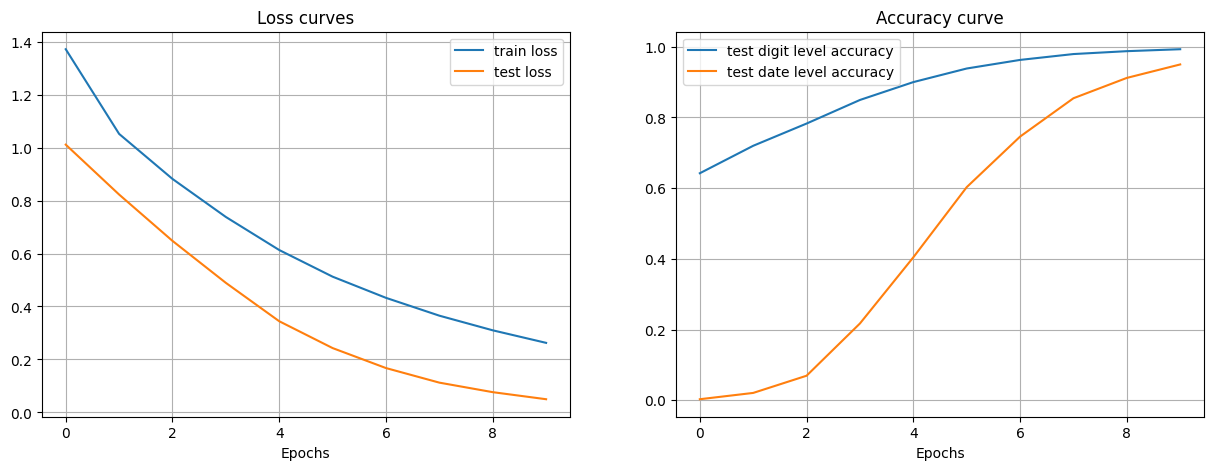

In [27]:
# Visualizing the loss and accuracy curves
fig,ax = plt.subplots(1,2,figsize= (15,5))
ax[0].plot(np.arange(epochs), train_losses, label = "train loss")
ax[0].plot(np.arange(epochs), test_losses, label = "test loss")
ax[1].plot(np.arange(epochs), test_digit_acccuracy, label = "test digit level accuracy")
ax[1].plot(np.arange(epochs), test_date_accuracy, label = "test date level accuracy")
ax[0].set_title("Loss curves")
ax[1].set_title("Accuracy curve")
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel("Epochs")
ax[1].set_xlabel("Epochs")
ax[0].grid()
ax[1].grid()

In [30]:
y_true = torch.cat(targets).view(-1).cpu().detach().numpy()
y_pred = torch.cat(predictions).view(-1).cpu().detach().numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41100
           1       1.00      1.00      1.00     19683
           2       1.00      1.00      1.00     14806
           3       0.97      0.94      0.95      4560
           4       0.99      0.99      0.99      4483
           5       0.98      0.98      0.98      4545
           6       0.98      0.98      0.98      4469
           7       1.00      1.00      1.00      4525
           8       0.97      0.95      0.96      5727
           9       0.99      1.00      0.99     24102

    accuracy                           0.99    128000
   macro avg       0.99      0.98      0.99    128000
weighted avg       0.99      0.99      0.99    128000

